## Import

In [ ]:
import numpy as np
import random
import os
import math

from glob import glob
import pandas as pd
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models
from torchvision import transforms

: 

In [63]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Hyperparameters Setting

In [80]:
CFG = {
    'IMG_SIZE':128,
    'EPOCHS':10,
    'LEARNING_RATE':2e-3,
    'BATCH_SIZE':32,
    'SEED':41
}

## Fix RandomSeed

In [65]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [66]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.jpg')))
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.png')))
            
            # get label
            label_df = pd.read_csv(current_path+'/label.csv')
            label_list.extend(label_df['leaf_weight'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('\\')[-1].split('.')[0]))
    return img_path_list

In [67]:
all_img_path, all_label = get_train_data('./dataset/train')
test_img_path = get_test_data('./dataset/test')

## Train / Validation Split

In [68]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

## CustomDataset

In [69]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_path_list)

In [70]:
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

In [71]:
all_img_path[0]

'./dataset/train\\CASE01\\image\\CASE01_01.png'

In [72]:
train_transform(cv2.imread(all_img_path[0])).transpose(0,1).transpose(1,2).shape

torch.Size([128, 128, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


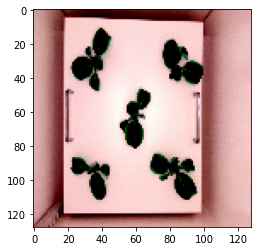

In [73]:
# from PIL import Image
# PIL_image = Image.fromarray(ndarray_image)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_transform(cv2.imread(all_img_path[0])).transpose(0,1).transpose(1,2))

In [74]:
# Get Dataloader
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Define Model Architecture

In [75]:
class CNNRegressor(torch.nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.regressor = nn.Linear(3136,1)


    def forward(self, x):
        # Simple CNN Model (Batch, 3, 128, 128 -> Batch, 64, 7, 7)
        # (Batch, 3, 128, 128)
        x = self.layer1(x)
        # (Batch, 8, 64, 64)
        x = self.layer2(x)
        # (Batch, 16, 32, 32)
        x = self.layer3(x)
        # (Batch, 32, 16, 16)
        x = self.layer4(x)
        # (Batch, 64, 7, 7) -> Flatten (Batch, 64*7*7(=3136))
        x = torch.flatten(x, start_dim=1)
        # Regressor (Batch, 3136) -> (Batch, 1)
        out = self.regressor(x)
        return out

## Train

In [76]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device):
    model.to(device)

    # Loss Function
    criterion = nn.L1Loss().to(device)
    best_mae = 9999
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img)
            # Calc loss
            loss = criterion(logit.squeeze(1), label)

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        if scheduler is not None:
            scheduler.step()
            
        # Evaluation Validation set
        vali_mae = validation(model, vali_loader, criterion, device)
        
        print(f'Epoch [{epoch}] Train MAE : [{np.mean(train_loss):.5f}] Validation MAE : [{vali_mae:.5f}]\n')
        
        # Model Saved
        if best_mae > vali_mae:
            best_mae = vali_mae
            torch.save(model.state_dict(), './saved/best_model.pth')
            print('Model Saved.')

In [77]:
def validation(model, vali_loader, criterion, device):
    model.eval() # Evaluation
    vali_loss = []
    with torch.no_grad():
        for img, label in tqdm(iter(vali_loader)):
            img, label = img.float().to(device), label.float().to(device)

            logit = model(img)
            loss = criterion(logit.squeeze(1), label)
            
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss

## Run!!

In [82]:
model = CNNRegressor().to(device)

optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

train(model, optimizer, train_loader, vali_loader, scheduler, device)

100%|██████████| 40/40 [01:01<00:00,  1.54s/it]


Epoch [1] Train MAE : [64.48207] Validation MAE : [44.01727]

Model Saved.


100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


Epoch [2] Train MAE : [47.43020] Validation MAE : [1305.50899]



100%|██████████| 40/40 [01:01<00:00,  1.54s/it]


Epoch [3] Train MAE : [86.31452] Validation MAE : [81.43506]



100%|██████████| 40/40 [00:58<00:00,  1.46s/it]


Epoch [4] Train MAE : [55.96909] Validation MAE : [43.97063]

Model Saved.


100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


Epoch [5] Train MAE : [30.76779] Validation MAE : [28.22738]

Model Saved.


100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


Epoch [6] Train MAE : [25.96817] Validation MAE : [53.83762]



100%|██████████| 40/40 [01:02<00:00,  1.57s/it]


Epoch [7] Train MAE : [23.45901] Validation MAE : [19.70783]

Model Saved.


100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Epoch [8] Train MAE : [19.90909] Validation MAE : [127.39199]



100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


Epoch [9] Train MAE : [18.49891] Validation MAE : [32.24288]



100%|██████████| 40/40 [00:59<00:00,  1.48s/it]

Epoch [10] Train MAE : [14.85386] Validation MAE : [48.13690]



## Inference

In [83]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.float().to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.squeeze(1).detach().cpu()

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [84]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Score가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('./saved/best_model.pth')
model = CNNRegressor().to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)

100%|██████████| 15/15 [05:02<00:00, 20.19s/it]


## Submission

In [86]:
preds

[58.58141326904297,
 143.59283447265625,
 -1.6936466693878174,
 55.583518981933594,
 65.65078735351562,
 61.60427474975586,
 -4.425544738769531,
 61.53095245361328,
 -1.798891544342041,
 67.88890838623047,
 -4.905154705047607,
 36.50437927246094,
 0.9731063842773438,
 36.09989547729492,
 -1.0720853805541992,
 61.85447311401367,
 61.105892181396484,
 40.899227142333984,
 64.83512878417969,
 138.255859375,
 46.81692123413086,
 -1.8089978694915771,
 -3.7091383934020996,
 -47.19990539550781,
 60.41492462158203,
 40.799072265625,
 94.99515533447266,
 51.88534927368164,
 61.219261169433594,
 67.640625,
 54.04057312011719,
 8.783977508544922,
 -3.8464059829711914,
 -1.1856470108032227,
 5.617023468017578,
 115.60542297363281,
 -3.015195369720459,
 67.87104034423828,
 -0.763853132724762,
 44.2213134765625,
 62.03602981567383,
 58.70888900756836,
 -2.0447425842285156,
 29.92577362060547,
 62.877384185791016,
 27.742185592651367,
 62.270790100097656,
 43.147220611572266,
 -17.81831932067871,
 47

In [87]:
submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv('./submit.csv', index=False)

In [ ]:
a=1

: 